In [ ]:
import numpy as np
import random
import pandas as pd

def log_likelihood(Z_n, omega_n, R, C, sigma):
    """
    Calculates the likelihood of observing the measured impedance data given 
    a specific circuit model and its parameters.

    Args:
        Z_i (complex): Measured impedance at frequency omega_i.
        omega_i (float): Angular frequency.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Likelihood value.
    """
    
    # Calculate impedance from the circuit model
    z_omega_i = circuit_impedance(omega_n, R, C)
    log_likelihood_value = -(1 / (2 * sigma**2)) * abs(Z_n - z_omega_i)**2 - 0.5 * np.log(2 * np.pi * sigma**2)

    return log_likelihood_value  # Return the log-likelihood

def circuit_impedance(omega_n, R, C):
    """
    Calculates the impedance of the circuit model at given frequencies.

    Args:
        omega_n (list or numpy array): Angular frequencies.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.

    Returns:
        numpy array: Impedances of the circuit model for each frequency.
    """
    
    z_omega_n = np.zeros_like(omega_n, dtype=complex)  # Initialize an array to store impedances

    for i in range(len(R)):
        z_omega_n += R[i] / (1 + 1j * omega_n * R[i] * C[i])  # Vectorized calculation

    return z_omega_n

def log_prior(R, C, R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Calculates the prior probability of the circuit parameters.

    Args:
        R (list): List of resistance values.
        C (list): List of capacitance values.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        float: Prior probability value.
    """
    
    for r in R:
        if not (R_min <= r <= R_max):
            return -np.inf  # Prior is 0 if resistance is outside the allowed range
    for c in C:
        if not (C_min <= c <= C_max):
            return -np.inf  # Prior is 0 if capacitance is outside the allowed range
    
    # If all parameters are within the allowed range, use uniform prior
    return 0  # Log of a uniform distribution is 0  

def log_posterior(omega_n, Z_n, K, R, C, sigma):
    """
    Calculates the posterior probability of the circuit parameters given the 
    observed data and the prior.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R (list): List of resistance values.
        C (list): List of capacitance values.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Posterior probability value.
    """   
    log_prior_prob = log_prior(R, C)
    if log_prior_prob == -np.inf:
        return -np.inf  # If log-prior is -inf, log-posterior is also -inf

    log_likelihood_prob = 0
    
    log_likelihood_prob += np.sum(log_likelihood(Z_n, omega_n, R, C, sigma))

    log_posterior_prob = log_likelihood_prob + log_prior_prob
    return log_posterior_prob  # Return the un-logged posterior probability


def metropolis(omega_n, Z_n, K, sigma, n_iterations=10000, burn_in=1000, 
              R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Performs Metropolis sampling to estimate the circuit parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        sigma (float): Standard deviation of the measurement noise.
        n_iterations (int, optional): Number of MCMC iterations. Defaults to 10000.
        burn_in (int, optional): Number of initial samples to discard. Defaults to 1000.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        tuple: A tuple containing the accepted R and C samples.
    """

    # Initialize parameters
    R_current = [np.random.uniform(R_min, R_max) for _ in range(K)]
    C_current = [np.random.uniform(C_min, C_max) for _ in range(K)]
    accepted_proposals = 0
    # Store accepted samples
    R_samples = []
    C_samples = []
    
    omega_n = np.array(omega_n)
    sample_rejection = 20
    sample_rejection_count = 0
    
    thinning_interval = 20  # Sample every 20 steps

    for i in range(n_iterations):
        # Propose new parameters
        R_proposal = [r + np.random.normal(0, 10) for r in R_current]
        C_proposal = [c + np.random.normal(0, 5.77e-9) for c in C_current]

        # Calculate posterior probabilities
        log_posterior_current = log_posterior(omega_n, Z_n, K, R_current, C_current, sigma)
        log_posterior_proposal = log_posterior(omega_n, Z_n, K, R_proposal, C_proposal, sigma)

        # Calculate log of acceptance ratio
        log_acceptance_ratio = log_posterior_proposal - log_posterior_current
        acceptance_ratio = min(1, log_acceptance_ratio)  # 0 if log_acceptance_ratio is positive, else log_acceptance_ratio
        
        # Accept or reject proposal (using exp(acceptance_ratio) since acceptance_ratio is in log space)
        if np.log(random.uniform(0, 1)) < acceptance_ratio:
            R_current = R_proposal
            C_current = C_proposal
            accepted_proposals += 1
        # Store accepted samples after burn-in
        if i > burn_in and (i - burn_in) % thinning_interval == 0:
            if (sample_rejection_count < sample_rejection):
                sample_rejection_count += 1                
            else:
                sample_rejection_count = 0
                R_samples.append(R_current)
                C_samples.append(C_current)

    return R_current, C_current, accepted_proposals, R_samples, C_samples

def wbic(omega_n, Z_n, K, R_samples, C_samples, sigma):
    """
    Calculates the Widely Applicable Bayesian Information Criterion (WBIC) 
    for a given circuit model and its parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R_samples (list): List of accepted resistance samples from MCMC.
        C_samples (list): List of accepted capacitance samples from MCMC.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: WBIC value.
    """
    
    n = len(omega_n)
    beta = 1 / np.log(n)
    log_likelihood_sum = 0

    R_samples = np.array(R_samples)
    C_samples = np.array(C_samples)

    for i in range(n):
        Z_i = Z_n[i]  # Get the current Z_i
        omega_i = omega_n[i]  # Get the current omega_i

        # Vectorized calculation of impedance for all samples at once
        z_omega_i = np.sum(R_samples / (1 + 1j * omega_i * R_samples * C_samples), axis=1)  

        # Vectorized calculation of log-likelihood for all samples at once
        log_likelihood_sum += np.sum(-(1 / (2 * sigma**2)) * np.abs(Z_i - z_omega_i)**2 - np.log(np.sqrt(2 * np.pi * sigma**2)))

    wbic_value = - beta * log_likelihood_sum 
    return wbic_value


## Support functions

In [ ]:
import matplotlib.pyplot as plt

def find_best_fit_model(frequencies, Z_measured, sigma = 10, K_max=2, n_iterations=10000, burn_in=1000):
    wbic_values = []
    R_samples_n = []
    C_samples_n = []

    for k in range(1, K_max + 1):  # Check models with K=1, 2
        R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequencies, Z_measured, k, sigma, n_iterations=n_iterations, burn_in=burn_in)
        wbic_value = wbic(frequencies, Z_measured, k, R_samples, C_samples, sigma)
        wbic_values.append(wbic_value)
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)
        
    # Select the best model
    best_model = np.argmin(wbic_values) + 1  # +1 because K starts from 1
    return best_model, wbic_values, R_samples_n, C_samples_n

def single_mcmc(data_filename, K, sigma=10, iterations=10000, burn_in=1000, print_results=False):
    data = pd.read_csv(data_filename)
    frequency_list = data['Frequency']  # Hz
    Z_complex = np.array(data['Z_real']) + 1j * np.array( data['Z_imag'])

    R_samples = []
    C_samples = []
    R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequency_list, Z_complex, K, sigma, n_iterations=iterations, burn_in=burn_in)
    acceptance_rate = accepted_proposals / iterations * 100
    if print_results:
        print(f"Acceptance rate: {acceptance_rate:.2f}%")
        if len(R_n) == 1:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}")
        else:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}\t{np.mean(R_n[1]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}\t{np.mean(C_n[1]):.2e}")
        print('')

    results = {
        'R_n': R_n,
        'C_n': C_n,
        'R_samples': R_samples,
        'C_samples': C_samples,
        'acceptance_rate': acceptance_rate,
        'frequency_list': frequency_list,
        'Z_complex': Z_complex
    }
    return results

def impedance_plot(frequencies, Z_measured, R, C, ax=None): 
    if ax is None:
        ax = plt.gca()  # Get the current axes if none is provided

    Z_model = [circuit_impedance(omega, R, C) for omega in frequencies]

    ax.plot(frequencies, np.real(Z_model), label='Calculated Z_real')
    ax.plot(frequencies, np.imag(Z_model), label='Calculated Z_imag')
    ax.plot(frequencies, np.real(Z_measured), 'o', label='Measured Z_real')
    ax.plot(frequencies, np.imag(Z_measured), 'o', label='Measured Z_imag')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Impedance')
    ax.set_title('Impedance vs Frequency')
    ax.legend()
    ax.grid()

def R_C_plot(R_samples, C_samples, ax_r, ax_c):
    if ax_r is None:
        return
    if ax_c is None:
        return
    ax_r.plot(R_samples, label='Resistance (Ohms)')
    ax_r.set_title('R_n values')
    ax_r.set_xlabel('Iteration')
    ax_r.set_ylabel('Value')
    ax_r.legend()

    ax_c.plot(C_samples, label='Capacitance (Farads)')    
    ax_c.set_title('C_n values')
    ax_c.set_xlabel('Iteration')
    ax_c.set_ylabel('Value')
    ax_c.legend()

def sort_samples(R_samples, C_samples):
    """
    Sorts the sublists in R_samples and rearranges the corresponding sublists in C_samples accordingly.
    
    Parameters:
        R_samples (list of lists): The main list to be sorted.
        C_samples (list of lists): The secondary list whose elements follow the sorting of R_samples.

    Returns:
        tuple: Sorted R_samples and adjusted C_samples.
    """
    sorted_R_samples = []
    sorted_C_samples = []

    if isinstance(R_samples, float):
        return R_samples, C_samples
    if isinstance(C_samples, float):
        return R_samples, C_samples
    for foo, bar in zip(R_samples, C_samples):
        # Combine the lists as pairs, sort by the first element, and unpack
        combined = sorted(zip(foo, bar), key=lambda x: x[0])
        # Separate them back into two lists
        sorted_foo, sorted_bar = zip(*combined)
        sorted_R_samples.append(list(sorted_foo))
        sorted_C_samples.append(list(sorted_bar))

    return sorted_R_samples, sorted_C_samples

def sort_linked_arrays_1d(R_k, C_k):
    """
    Sorts the elements of R_k and rearranges the corresponding elements in C_k accordingly.
    
    Parameters:
        R_k (list): The main list to be sorted.
        C_k (list): The secondary list whose elements follow the sorting of R_k.

    Returns:
        tuple: Sorted R_k and adjusted C_k.
    """
    # Combine R_k and C_k, sort by the values in R_k, and unpack
    combined = sorted(zip(R_k, C_k), key=lambda x: x[0])
    sorted_R_k, sorted_C_k = zip(*combined)
    return list(sorted_R_k), list(sorted_C_k)


[[[10], [20], [30]], [[10], [20], [30]]]
[[[1e-09], [2e-09], [3e-09]], [[1e-09], [2e-09], [3e-09]]]


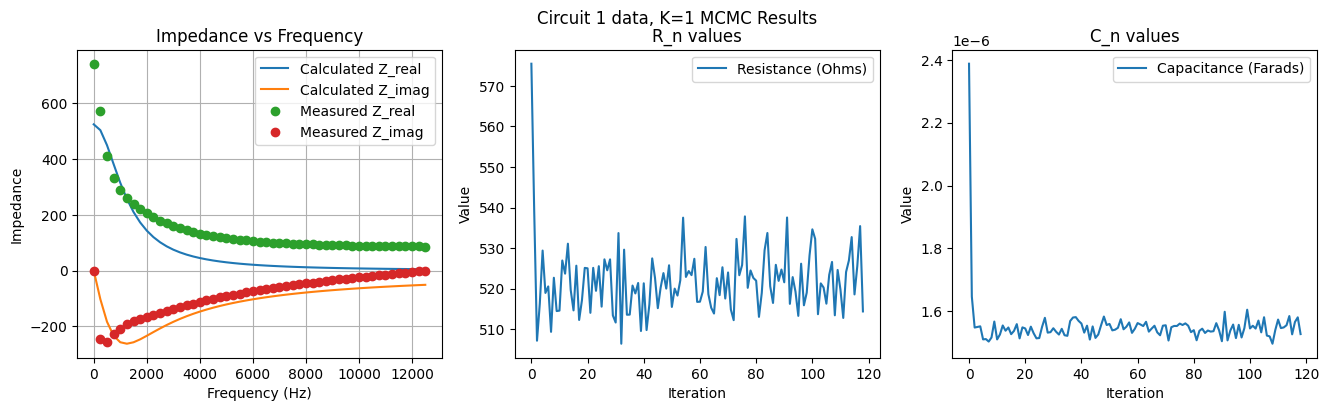

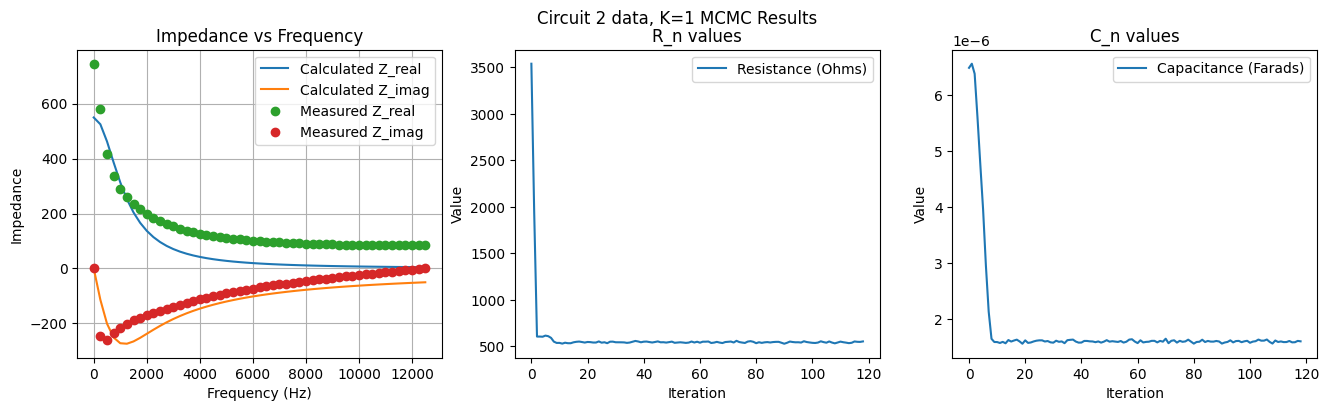

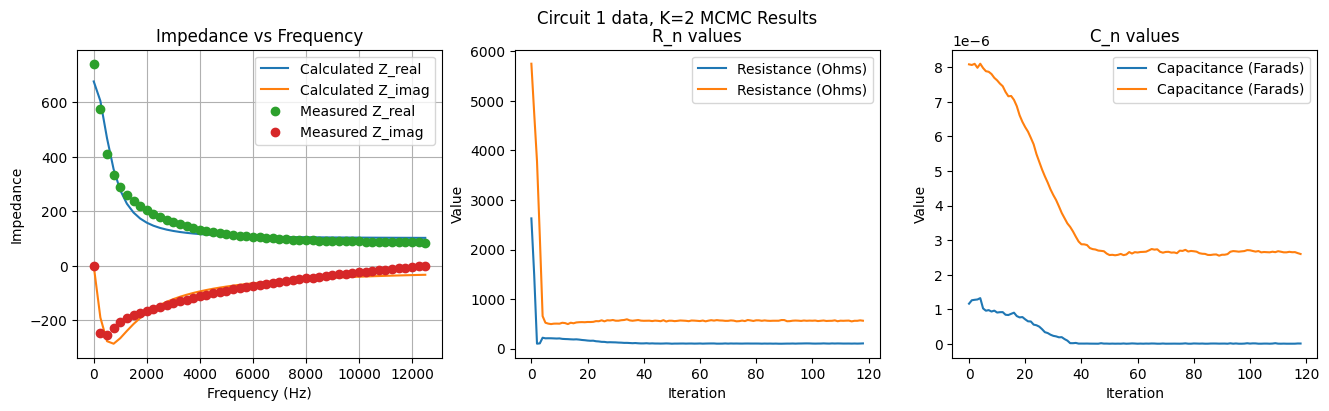

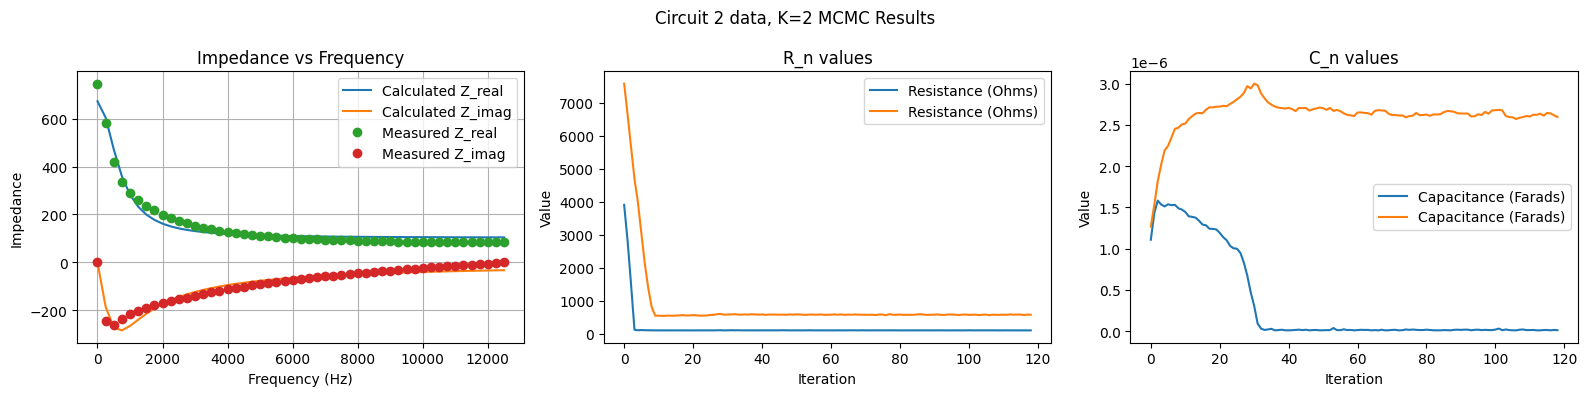

In [14]:
results = single_mcmc('circuit1_data.csv', 1, iterations = 50000, burn_in = 0)
fig_c1_k1, (ax_c1_k1_1, ax_c1_k1_2, ax_c1_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c1_k1.suptitle('Circuit 1 data, K=1 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k1_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k1_2, ax_c=ax_c1_k1_3)  

results = single_mcmc('circuit2_data.csv', 1, iterations = 50000, burn_in = 0)
fig_c2_k1, (ax_c2_k1_1, ax_c2_k1_2, ax_c2_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c2_k1.suptitle('Circuit 2 data, K=1 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k1_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k1_2, ax_c=ax_c2_k1_3)  

results = single_mcmc('circuit1_data.csv', 2, iterations = 50000, burn_in = 0)
fig_c1_k2, (ax_c1_k2_1, ax_c1_k2_2, ax_c1_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c1_k2.suptitle('Circuit 1 data, K=2 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k2_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k2_2, ax_c=ax_c1_k2_3)  

results = single_mcmc('circuit2_data.csv', 2, iterations = 50000, burn_in = 0)
fig_c2_k1, (ax_c2_k2_1, ax_c2_k2_2, ax_c2_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c2_k1.suptitle('Circuit 2 data, K=2 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k2_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k2_2, ax_c=ax_c2_k2_3)  

plt.tight_layout()
plt.show()

# MCMC

Finding best fit model for circuit1_data.csv: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Best fit model for circuit1_data.csv: K = 2

Estimated R value for R[0]: 520.71
Estimated C value for C[0]: 1.54e-06

Estimated R value for R[1]: 130.77	544.39
Estimated R value for C[1]: 1.42e-06	4.33e-06

[0. 1.]


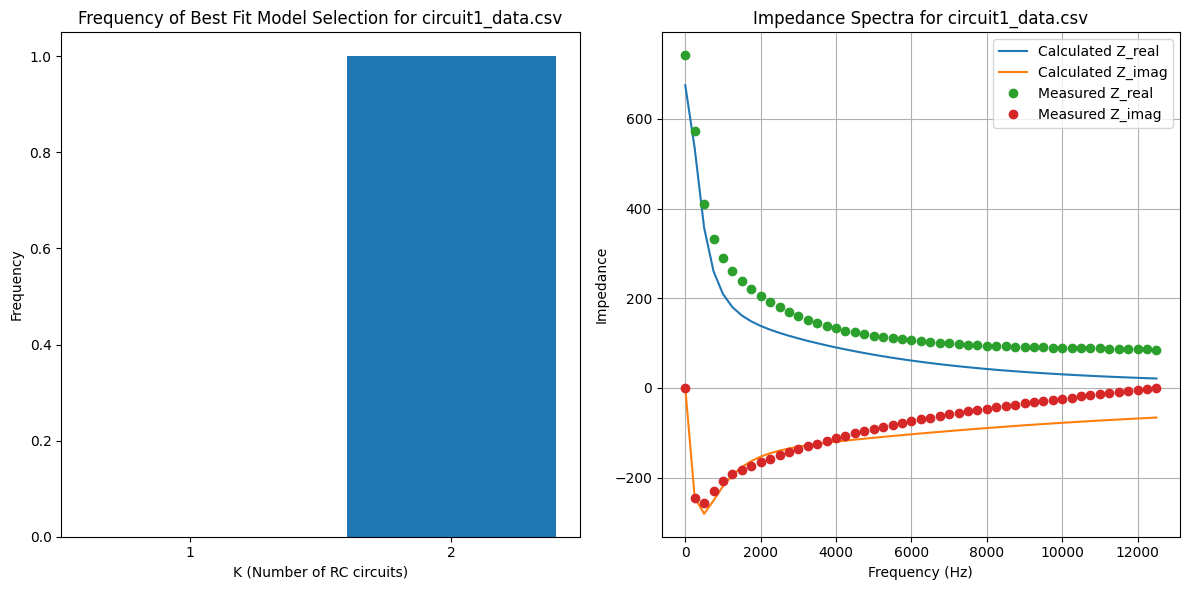

Finding best fit model for circuit2_data.csv: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


Best fit model for circuit2_data.csv: K = 2

Estimated R value for R[0]: 542.27
Estimated C value for C[0]: 1.60e-06

Estimated R value for R[1]: 102.22	565.85
Estimated R value for C[1]: 9.68e-07	2.86e-06

[0. 1.]


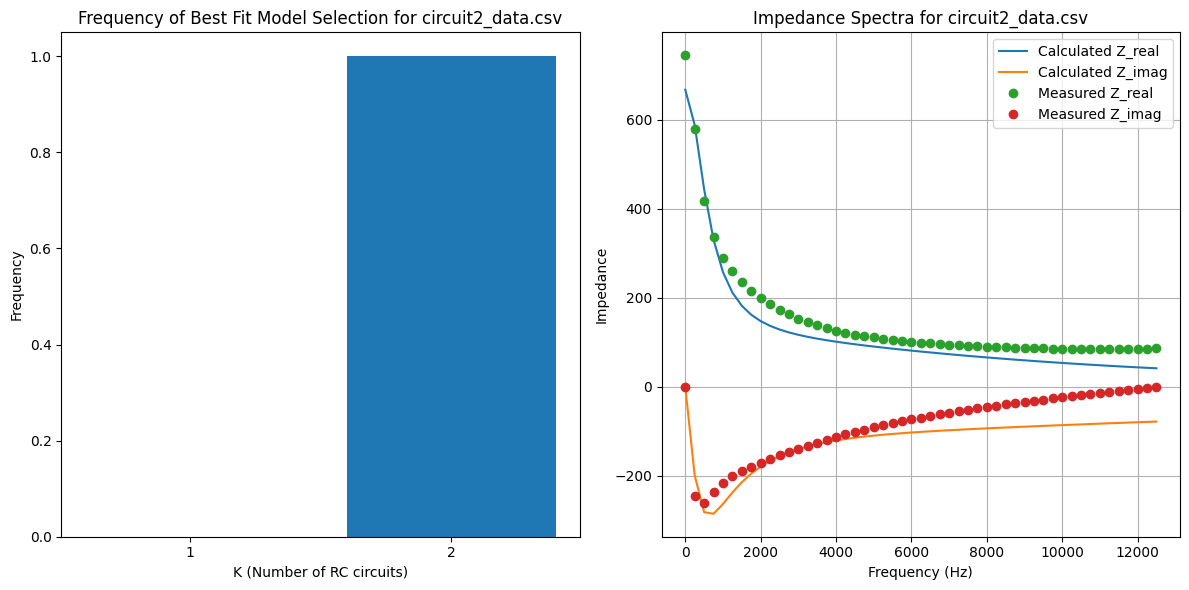

Finding best fit model for generated_data_1.csv: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Best fit model for generated_data_1.csv: K = 2

Estimated R value for R[0]: 1498.99
Estimated C value for C[0]: 5.03e-07

Estimated R value for R[1]: 214.88	1291.03
Estimated R value for C[1]: 5.55e-06	5.62e-07

[0. 1.]


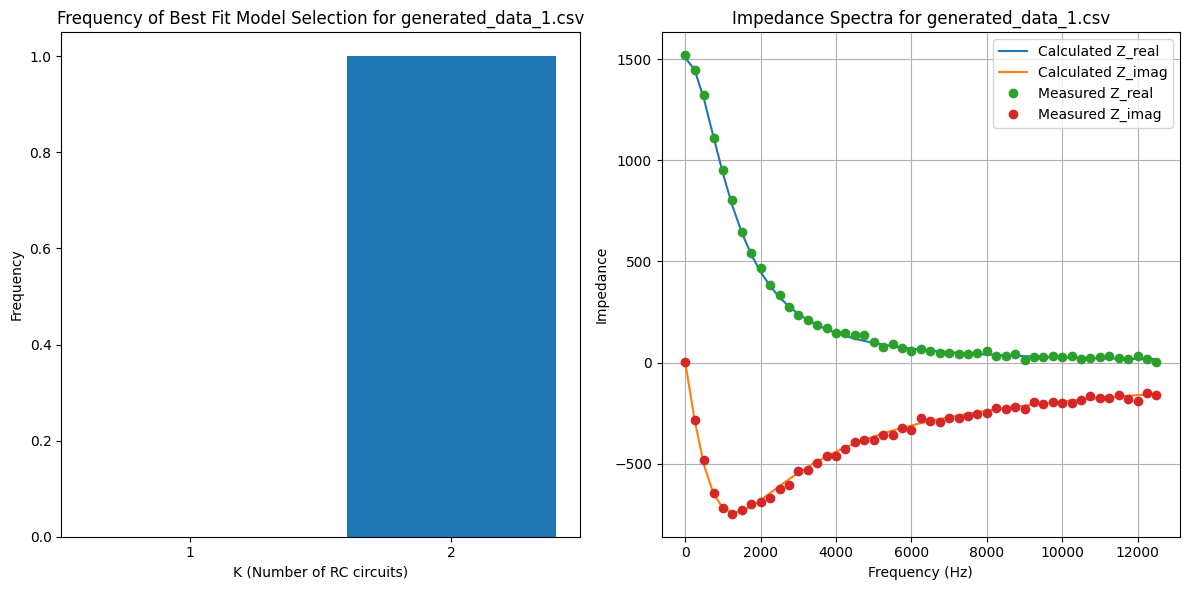

Finding best fit model for generated_data_2.csv: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Best fit model for generated_data_2.csv: K = 2

Estimated R value for R[0]: 5300.91
Estimated C value for C[0]: 5.78e-07

Estimated R value for R[1]: 811.05	4982.45
Estimated R value for C[1]: 4.96e-07	1.01e-06

[0. 1.]


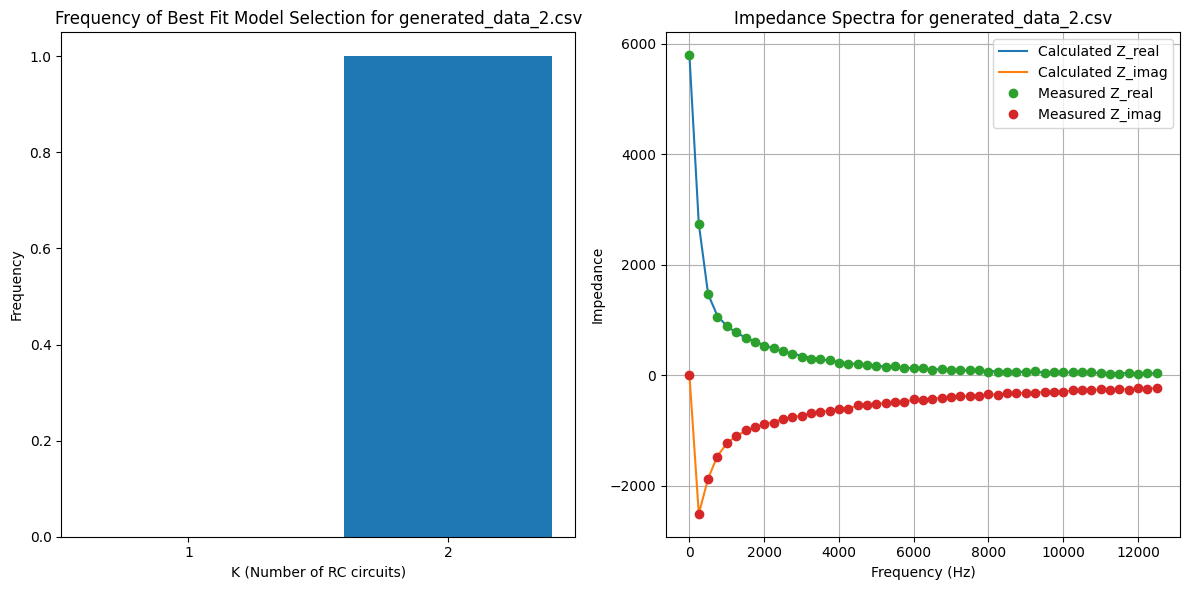

In [26]:
from tqdm import tqdm

custom_data_files = ["circuit1_data.csv", "circuit2_data.csv","generated_data_1.csv", "generated_data_2.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 2

    K_n = np.zeros(K_max)
    for i in tqdm(range(5), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=20_000, K_max=K_max, burn_in=10_000)
        K_n[best_model - 1] += 1

        R_samples_sorted, C_samples_sorted = sort_samples(R_samples, C_samples)
         
        for k in range (K_max):
            if k == 0:
                R_k = np.mean(R_samples_sorted[k])
                C_k = np.mean(C_samples_sorted[k])
            if k == 1:
                C_k = []
                R_k = []
                test = R_samples_sorted[k]
                r_value_0 = 0
                r_value_1 = 0
                c_value_0 = 0
                c_value_1 = 0
                for x in range(len(R_samples_sorted[k])):
                    r_value_0 += R_samples_sorted[k][x][0]
                    r_value_1 += R_samples_sorted[k][x][1]
                    c_value_0 += C_samples_sorted[k][x][0]
                    c_value_1 += C_samples_sorted[k][x][1]

                R_k = (r_value_0/len(R_samples_sorted[k]), r_value_1/len(R_samples_sorted[k]))
                C_k = (c_value_0/len(C_samples_sorted[k]), c_value_1/len(C_samples_sorted[k]))

                R_k, C_k = sort_linked_arrays_1d(R_k, C_k)   

            else:
                pass
            if len(R_samples_n) < K_max:
                R_samples_n.extend([[] for _ in range(K_max - len(R_samples_n))])
            if len(C_samples_n) < K_max:
                C_samples_n.extend([[] for _ in range(K_max - len(C_samples_n))])
                       
            R_samples_n[k].append(R_k)
            C_samples_n[k].append(C_k)
       

    K_best = np.argmax(K_n) + 1
    print(f"Best fit model for {file}: K = {K_best}\n")

    final_r = []
    final_c = []
    for i in range(K_best):
        if i==0:
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[i]):.2e}")
        if i==1:
            r_value_0 = 0
            r_value_1 = 0
            c_value_0 = 0
            c_value_1 = 0
            for x in range(len(R_samples_n[i])):
                r_value_0 += R_samples_n[i][x][0]
                r_value_1 += R_samples_n[i][x][1]
                c_value_0 += C_samples_n[i][x][0]
                c_value_1 += C_samples_n[i][x][1]
            R_1 = r_value_0/len(R_samples_n[i])
            R_2 = r_value_1/len(R_samples_n[i])
            C_1 = c_value_0/len(C_samples_n[i])
            C_2 = c_value_1/len(C_samples_n[i])

            final_r.append(R_1)
            final_r.append(R_2)
            final_c.append(C_1)
            final_c.append(C_2) 
            # final_c.append(np.array(np.float64(C_1), np.float64(C_2)))
            print(f"Estimated R value for R[{i}]: {R_1:.2f}\t{R_2:.2f}")
            print(f"Estimated R value for C[{i}]: {C_1:.2e}\t{C_2:.2e}")
        print('')

    impedance_values = circuit_impedance(custom_frequencies, final_r, final_c)
    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis

    # Plotting the impedance spectra
    plt.subplot(1, 2, 2)
    plt.plot(custom_frequencies, np.real(impedance_values), label='Calculated Z_real')
    plt.plot(custom_frequencies, np.imag(impedance_values), label='Calculated Z_imag')
    plt.plot(custom_frequencies, np.real(custom_Z_measured), 'o', label='Measured Z_real')
    plt.plot(custom_frequencies, np.imag(custom_Z_measured), 'o', label='Measured Z_imag')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance')
    plt.title(f'Impedance Spectra for {file}')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # R_n_2 = [800, 5000]
# C_n_2 = [500e-9, 1e-6]

# R_n_1 = [1500,]
# C_n_1 = [500e-9]